# README

#Setup

In [13]:
import numpy as np
import pandas as pd
import math
import itertools
import random
import torch
import os
import gzip
import json
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForMaskedLM, DataCollatorForWholeWordMask, DataCollatorForLanguageModeling, pipeline
from transformers import AdamW, get_linear_schedule_with_warmup, TrainerCallback
from sklearn.model_selection import StratifiedKFold
import shutil
from datasets import load_metric
import gc
gc.enable()
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, BayesianRidge, Perceptron, SGDRegressor

# Constants

In [14]:
BASE_PATH = '/home/masa1357/Dockerdata/gitfile/kaggle_clrp_1st_place_solution'

In [15]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 28
seed_everything(seed=SEED)
MAX_LENGTH = 256

In [16]:
# fine-tuned model paths
# adjust path if you have saved the models in different directories
ALBERT_TRAINED_1 = os.path.join(BASE_PATH, 'models/albert-xxlarge-2-models')#OK
ALBERT_TRAINED_2 = os.path.join(BASE_PATH, 'models/albert-xxlarge-low-lr')#OK
ALBERT_TRAINED_3 = os.path.join(BASE_PATH, 'models/ALBERT_3/albert-xxlarge-all-data')#OK
DEBERTA_TRAINED_1 = os.path.join(BASE_PATH, 'models/deberta-large')#OK
DEBERTA_TRAINED_2 = os.path.join(BASE_PATH, 'models/deberta-large-low-lr')#OK
DEBERTA_TRAINED_3 = os.path.join(BASE_PATH, 'models/deberta-augmented-continued')#OK
ROBERTA_TRAINED_1 = os.path.join(BASE_PATH, 'models/roberta-large-two-models')#OK
ELECTRA_TRAINED_1 = os.path.join(BASE_PATH, 'models/electra-large')#OK

In [17]:
# ensemble model paths
RIDGE_ENSEMBLE_1 = os.path.join(BASE_PATH, 'models/electra-larger-ensemble')
RIDGE_ENSEMBLE_2 = os.path.join(BASE_PATH, 'models/huge-ensemble')

# Functions

In [18]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [19]:
def predict_fast(model_name=None, data=None, init_model=None, tokenizer=None, num_labels=1, is_multilabel=False, output_logits=False, use_softmax=False):
  device = "cuda:0"
  tokenizer = AutoTokenizer.from_pretrained(model_name) if model_name else tokenizer
  config = AutoConfig.from_pretrained(model_name, num_labels=num_labels) if model_name else None
  model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config) if model_name else init_model
  model.to(device)
  model.eval()
  y_pred = []
  batches = chunks(data, 32)
  for batch in tqdm(batches):
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
    input_ids = inputs['input_ids'].to(device)
    attention = inputs['attention_mask'].to(device)
    inputs = {
        'input_ids': input_ids,
        'attention_mask': attention
    }
    with torch.no_grad():        
          outputs = model(**inputs)
    if not use_softmax:
      logits = outputs[0].detach().cpu().numpy().squeeze().tolist()
    else:
      logits = nn.functional.softmax(outputs.logits, dim=-1).detach().cpu().numpy().squeeze().tolist()
    if is_multilabel and not output_logits:
      logits = np.argmax(logits, axis=-1)
    y_pred.extend(logits)
  del model
  gc.collect()
  return y_pred

In [20]:
# def predict_fast(model_name=None, data=None, init_model=None, tokenizer=None, num_labels=1, is_multilabel=False, output_logits=False, use_softmax=False, output_attentions=True):
#     device = "cuda:0"
#     tokenizer = AutoTokenizer.from_pretrained(model_name) if model_name else tokenizer
#     config = AutoConfig.from_pretrained(model_name, num_labels=num_labels, output_attentions=output_attentions) if model_name else None
#     model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config) if model_name else init_model
#     model.to(device)
#     model.eval()
#     y_pred = []
#     attention_scores = []
#     tokenized_texts = []
#     batches = chunks(data, 32)
#     for batch in tqdm(batches):
#         inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH)
#         input_ids = inputs['input_ids'].to(device)
#         attention = inputs['attention_mask'].to(device)
#         inputs = {
#             'input_ids': input_ids,
#             'attention_mask': attention
#         }
#         with torch.no_grad():        
#             outputs = model(**inputs)
#         if not use_softmax:
#             logits = outputs[0].detach().cpu().numpy().squeeze().tolist()
#         else:
#             logits = nn.functional.softmax(outputs.logits, dim=-1).detach().cpu().numpy().squeeze().tolist()
#         if is_multilabel and not output_logits:
#             logits = np.argmax(logits, axis=-1)
#         y_pred.extend(logits)

#         if output_attentions:
#             # Average the attention scores over all heads for each layer
#             attn = outputs[-1]
#             avg_attn = [torch.mean(layer_attn, dim=1) for layer_attn in attn]
#             attention_scores.extend(avg_attn)
        
#         # Convert input IDs back to tokens
#         tokens = [tokenizer.convert_ids_to_tokens(input_id) for input_id in input_ids.cpu().numpy()]
#         tokenized_texts.extend(tokens)

#     del model
#     gc.collect()
#     if output_attentions:
#         return y_pred, attention_scores, tokenized_texts
#     else:
#         return y_pred


In [21]:
def rms(y_actual, y_predicted):
  return mean_squared_error(y_actual, y_predicted, squared=False)

In [22]:
from joblib import load

In [23]:
def make_ensembler_predictions(fold_predictions, ensembler_dirs, return_mean=True):
  final_predictions = []
  for idx, predictions in enumerate(fold_predictions):
    #print(f"Length of predictions for fold {idx}: {len(predictions)}")  # Change this line
    clf = load(ensembler_dirs[idx])
    n_features = clf.coef_.shape[-1]  # The number of features used by the model
    #print(f"The model was trained with {n_features} features.")
    Y = np.column_stack(predictions)
    y_preds = clf.predict(Y)
    final_predictions.append(y_preds)
  
  if return_mean:
    preds = np.vstack(final_predictions)
    del final_predictions
    return np.mean(preds, axis=0)
  else:
    return final_predictions

# Load test data

In [24]:
# You will need to place the test data in /data/test/test.csv
test_df = pd.read_csv(os.path.join(BASE_PATH, 'connected.csv'))
#test_df = pd.read_csv(os.path.join(BASE_PATH, 'data/training/original/train.csv'))
test_tx = [str(t) for t in test_df.excerpt.values]


In [25]:
# import torch, gc
# gc.collect()
# torch.cuda.empty_cache()


# Prediction

In [27]:
# Getting transformer predictions

model_dirs = [
    ALBERT_TRAINED_1,
    DEBERTA_TRAINED_1,
    ALBERT_TRAINED_2,
    DEBERTA_TRAINED_2,
    ROBERTA_TRAINED_1,
    ELECTRA_TRAINED_1
]

fold_predictions = {
    'fold_0': [],
    'fold_1': [],
    'fold_2': [],
    'fold_3': [],
    'fold_4': [],
    'fold_5': [],
}

fold_attention_scores = {
    'fold_0': [],
    'fold_1': [],
    'fold_2': [],
    'fold_3': [],
    'fold_4': [],
    'fold_5': [],
}

fold_tokens = {
    'fold_0': [],
    'fold_1': [],
    'fold_2': [],
    'fold_3': [],
    'fold_4': [],
    'fold_5': [],
}


# for i in range(6):
#     for model in model_dirs:
#         preds, attn_scores, tokens = predict_fast(model_name=os.path.join(model, 'model_fold_' + str(i) + '/best'), data=test_tx, output_attentions=True)
#         fold_predictions['fold_' + str(i)].append(np.array(preds))
#         fold_attention_scores['fold_' + str(i)].append([attn.cpu().numpy() for attn in attn_scores])
#         fold_tokens['fold_' + str(i)].append(tokens)

for i in range(6):
  for model in model_dirs:
    preds = predict_fast(model_name=os.path.join(model, 'model_fold_' + str(i) + '/best'), data=test_tx)
    fold_predictions['fold_' + str(i)].append(np.array(preds))


#   for model in model_dirs:
#     preds = predict_fast(model_name=os.path.join(model, 'model_fold_' + str(i) + '/best'), data=test_tx, output_attentions=True)
#     fold_predictions['fold_' + str(i)].append(np.array(preds))

# Getting predictions from special models
albert_single_preds = predict_fast(model_name=os.path.join(ALBERT_TRAINED_3), data=test_tx)#, output_attentions=True
deberta_bs_0 = predict_fast(model_name=os.path.join(DEBERTA_TRAINED_3, 'model_fold_0/best'), data=test_tx)#, output_attentions=True
deberta_bs_1 = predict_fast(model_name=os.path.join(DEBERTA_TRAINED_3, 'model_fold_1/best'), data=test_tx)#, output_attentions=True


517it [33:36,  3.90s/it]
517it [06:03,  1.42it/s]
517it [33:50,  3.93s/it]
517it [06:04,  1.42it/s]
517it [04:28,  1.92it/s]
517it [04:30,  1.91it/s]
517it [33:50,  3.93s/it]
517it [06:04,  1.42it/s]
517it [33:50,  3.93s/it]
517it [06:04,  1.42it/s]
517it [04:28,  1.92it/s]
517it [04:30,  1.91it/s]
517it [33:50,  3.93s/it]
517it [06:04,  1.42it/s]
517it [33:49,  3.93s/it]
517it [06:04,  1.42it/s]
517it [04:28,  1.93it/s]
517it [04:30,  1.91it/s]
517it [33:47,  3.92s/it]
517it [06:04,  1.42it/s]
517it [33:47,  3.92s/it]
517it [06:03,  1.42it/s]
517it [04:28,  1.93it/s]
517it [04:30,  1.91it/s]
517it [33:46,  3.92s/it]
517it [06:03,  1.42it/s]
517it [33:46,  3.92s/it]
517it [06:02,  1.42it/s]
517it [04:27,  1.93it/s]
517it [04:29,  1.92it/s]
517it [33:44,  3.92s/it]
517it [06:02,  1.43it/s]
517it [33:42,  3.91s/it]
517it [06:02,  1.43it/s]
517it [04:27,  1.93it/s]
517it [04:29,  1.92it/s]
517it [33:41,  3.91s/it]
517it [06:02,  1.43it/s]
517it [06:02,  1.43it/s]


In [28]:
# Get the attention scores and tokens for the first model of 'fold_0'
attn_scores_fold_0_model_0 = fold_attention_scores['fold_0'][0]
tokens_fold_0_model_0 = fold_tokens['fold_0'][0]

# For simplicity, let's just consider the attention scores from the last layer
last_layer_attn = attn_scores_fold_0_model_0[-1]

# The attention scores are a square matrix of shape (num_tokens, num_tokens)
# We are interested in the scores where the model is attending from the first token (index 0)
token_attention_scores = last_layer_attn[0, :]

for token, score in zip(tokens_fold_0_model_0, token_attention_scores):
    print(f"Token: {token}, Attention Score: {score}")

IndexError: list index out of range

In [ ]:
plottoken = ['[CLS]', '▁', '"', 'in', '▁the', '▁signal', '▁framework', ',', '▁digital', '▁signals', '▁are', '▁viewed', '▁as', '▁signals', '▁with', '▁discrete', '▁amplitude', 's', '▁at', '▁discrete', '▁times', '.', '▁if', '▁analog', '▁signals', '▁are', '▁converted', '▁to', '▁digital', '▁signals', ',', '▁they', '▁can', '▁be', '▁processed', '▁on', '▁a', '▁pc', '.', '▁digital', '▁signals', '▁have', '▁become', '▁in', 'dis', 'pens', 'able', '▁in', '▁a', '▁wide', '▁range', '▁of', '▁fields', '▁because', '▁they', '▁can', '▁be', '▁processed', '▁by', '▁a', '▁pc', '.', '"', '[SEP]', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
plotatt = [3.30366343e-01, 7.78757909e-04, 3.39608714e-02, 1.98185742e-02,
 7.35485414e-03, 5.50092477e-03, 3.65315005e-03, 5.03880624e-03,
 7.82421604e-03, 7.40415603e-03, 2.43676244e-03, 6.18395070e-03,
 3.92241636e-03, 2.44922284e-03, 2.19908979e-04, 2.91131367e-03,
 2.34702975e-03, 3.77532048e-03, 3.93782603e-03, 1.53067231e-04,
 1.07731605e-02, 3.29914084e-03, 5.27708093e-03, 3.34734842e-03,
 2.68101762e-03, 2.88168248e-03, 4.70565818e-03, 2.45802570e-03,
 1.05115185e-02, 2.88022123e-03, 6.07322727e-04, 2.26119091e-03,
 1.87722559e-03, 3.57772340e-04, 3.95839196e-03, 3.04403569e-04,
 2.09119683e-03, 1.15032122e-03, 5.16521791e-03, 9.69697954e-04,
 1.25976442e-03, 1.58434198e-03, 1.34717999e-03, 8.79996573e-04,
 2.72720121e-03, 3.64793055e-02, 2.27456912e-03, 7.52897467e-05,
 7.69481878e-04, 3.79535995e-05, 1.60713377e-03, 3.88922589e-03,
 1.38618536e-02, 9.29682399e-04, 6.77465647e-03, 1.47206406e-03,
 7.64503551e-04, 7.90627149e-04, 2.31919065e-03, 5.04711701e-04,
 3.16240650e-04, 1.30115193e-03, 1.71970413e-03, 1.41510653e-04,
 1.74445246e-04, 1.38753559e-03, 6.63956336e-04, 7.16868322e-04,
 2.35621003e-04, 1.32727297e-03, 1.75092282e-04, 1.42939296e-03,
 1.08454120e-03, 4.51889541e-03, 1.00558344e-03, 6.32098876e-04,
 7.12561130e-04, 2.03870673e-04, 4.81638708e-04, 3.96010495e-04,
 6.92728936e-05, 1.59351202e-03, 1.45863264e-03, 3.77084711e-04,
 1.00907171e-03, 5.88176015e-04, 8.53824138e-04, 2.96937674e-03,
 2.26963055e-03, 2.33674096e-03, 3.91443074e-03, 2.60744448e-04,
 3.53652872e-02, 3.30366433e-01]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 5))
plt.bar(plottoken, plotatt)
plt.title("Attention scores per token")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Remove '[CLS]' and '<pad>' tokens
exclude_tokens = ['[CLS]', '<pad>','[SEP]']
indices = [i for i, token in enumerate(plottoken) if token not in exclude_tokens]

filtered_tokens = [plottoken[i] for i in indices]
filtered_attention = [plotatt[i] for i in indices]

plt.figure(figsize=(20, 5))
plt.bar(filtered_tokens, filtered_attention)
plt.title("Attention scores per token")
plt.xticks(rotation=90)
plt.show()


# Ensembling

In [29]:
from joblib import load

In [30]:
ridge_dirs_1 = []
ridge_dirs_2 = []

for i in [1,2,4,5]:
  ridge_dirs_1.append(os.path.join(RIDGE_ENSEMBLE_1, 'model_fold_' + str(i) + '/ridge_model.joblib'))

ensemble_1_preds = make_ensembler_predictions(
    fold_predictions=[fold_predictions['fold_' + str(i)] for i in [1,2,4,5]],
    ensembler_dirs=ridge_dirs_1
)

In [31]:
for i in range(6):
  ridge_dirs_2.append(os.path.join(RIDGE_ENSEMBLE_2, 'model_fold_' + str(i) + '/ridge_model.joblib'))

#fold_predictions_modified = [fold[:-1] for fold in fold_predictions['fold_' + str(i)] for i in range(6)]

ensemble_2_preds = make_ensembler_predictions(
    fold_predictions=[fold_predictions['fold_' + str(i)] for i in range(6)],
    ensembler_dirs=ridge_dirs_2
)

In [32]:
bs_mean_preds = np.array(deberta_bs_0) * 0.5 + np.array(deberta_bs_1) * 0.5
bs_alb_mean_preds = np.array(albert_single_preds) * 0.65 + np.array(bs_mean_preds) * 0.35

In [33]:
final_predictions = np.array(ensemble_1_preds) * 3./8. + np.array(ensemble_2_preds) * 2./8. + np.array(bs_alb_mean_preds) * 3./8.
#final_predictions = np.array(ensemble_1_preds) * 0.5 + np.array(bs_alb_mean_preds) * 0.5

In [34]:
final_predictions

array([-0.6559222 , -0.6559222 , -0.6559222 , ..., -1.9050668 ,
       -1.56794175, -1.56794175])

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_df['target'], final_predictions)
mse = mean_squared_error(test_df['target'], final_predictions)


In [36]:
submission_df = pd.DataFrame({'id': test_df.id, 'target': test_df.target, 'Answer': final_predictions})
submission_df.to_csv(os.path.join(BASE_PATH, 'data/submission/submissionREF_connect.csv'))

## 可視化

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
correlation = submission_df['target'].corr(submission_df['Answer'])

In [39]:
submission_df

,id,target,Answer
0,B-2020_U1,-3,-0.655922
1,B-2020_U1,-3,-0.655922
2,B-2020_U1,-3,-0.655922
3,B-2020_U10,0,-1.406802
4,B-2020_U10,0,-1.406802
...,...,...,...
16518,C-2022-1_U94,-3,-0.431560
16519,C-2022-1_U94,-3,-0.431560
16520,D-2021_U49,1,-1.905067
16521,D-2022_U89,1,-1.567942


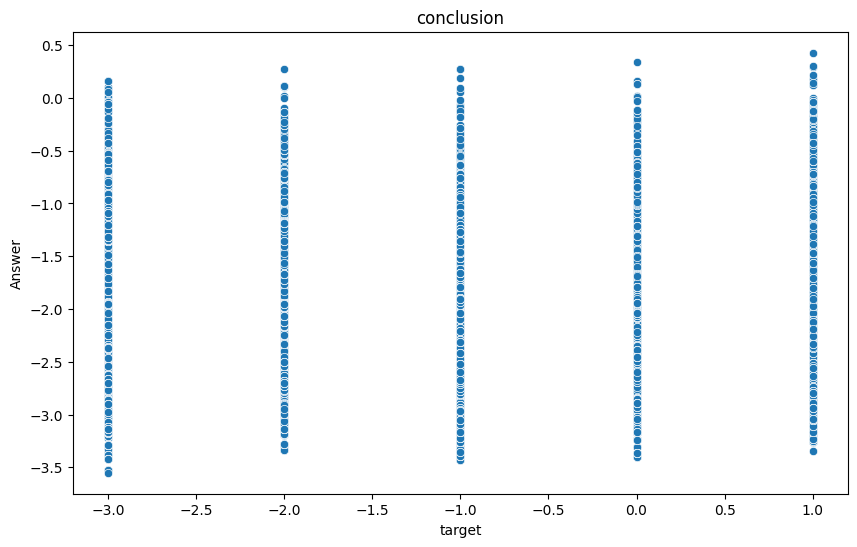

In [40]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=submission_df, x='target', y='Answer')

plt.title('conclusion')
plt.show()
# TODO Legend追加